## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

## Read Data

In [3]:

train_dir = r"D:\Cellula Technologies\Project 1\Python\Teeth_Dataset\Training"
test_dir = r"D:\Cellula Technologies\Project 1\Python\Teeth_Dataset\Testing"
val_dir = r"D:\Cellula Technologies\Project 1\Python\Teeth_Dataset\Validation"


IMG_SIZE = (224, 224)
BATCH_SIZE = 48

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


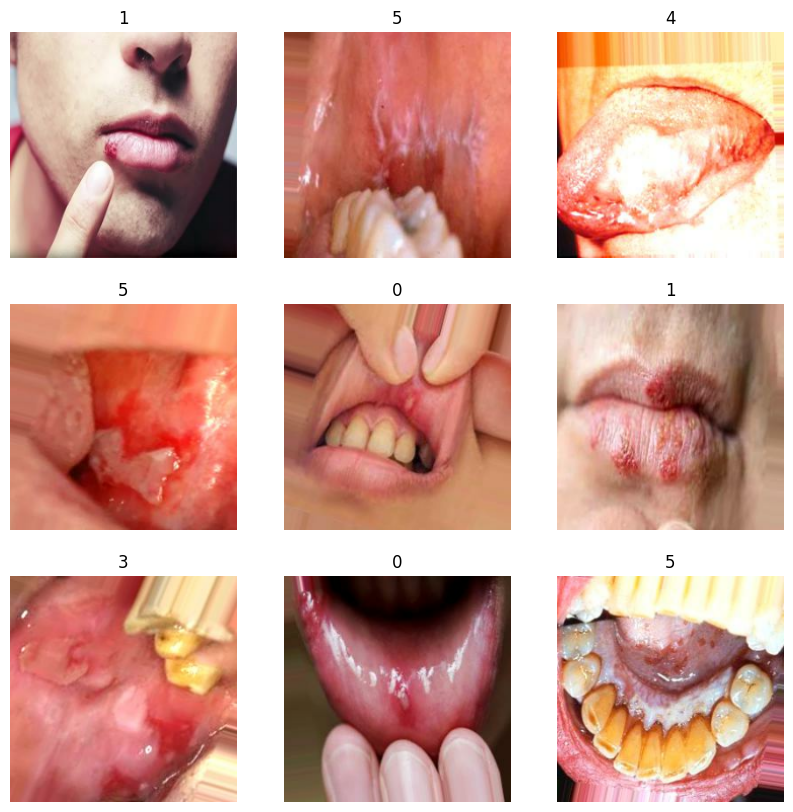

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Show distribution between Classes

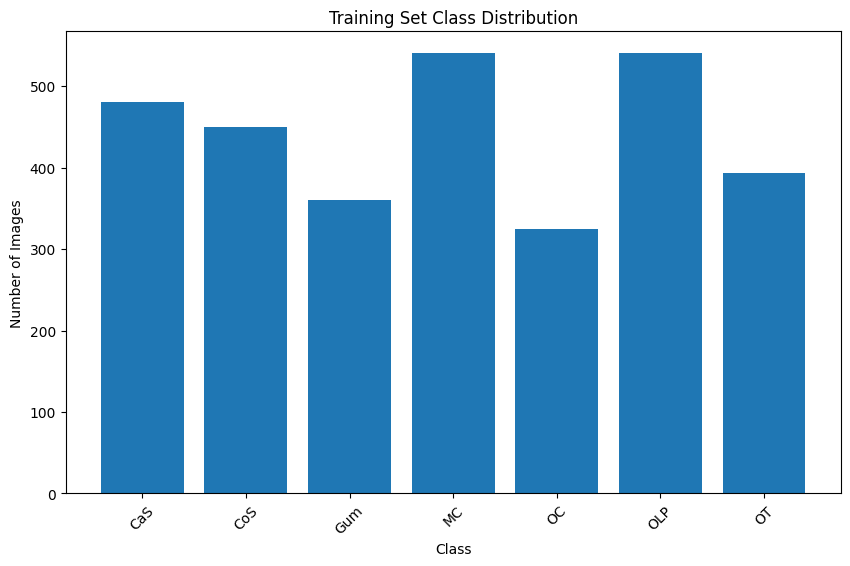

{'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}


In [5]:
import os
import matplotlib.pyplot as plt

train_dir = r"D:\Cellula Technologies\Project 1\Python\Teeth_Dataset\Training"  # غير المسار عندك

classes = os.listdir(train_dir)
class_counts = [len(os.listdir(os.path.join(train_dir, c))) for c in classes]

plt.figure(figsize=(10,6))
plt.bar(classes, class_counts)
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print(dict(zip(classes, class_counts)))


## Normalization & Augmentation

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 224  
BATCH_SIZE = 32
DATA_DIR = 'D:\Cellula Technologies\Project 1\Python\Teeth_Dataset\Training'
val_dir="D:\Cellula Technologies\Project 1\Python\Teeth_Dataset\Validation"



train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    # subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    # subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"عدد الفئات: {num_classes}")

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
عدد الفئات: 7


## Build Model

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# تحميل ResNet50 بدون الـ Top Layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# تثبيت وزن الـ base model (للبداية فقط)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2)



In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # ابدأ بـ 10 وشوف
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8603 - loss: 0.4359 - val_accuracy: 0.8969 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8726 - loss: 0.3927 - val_accuracy: 0.9173 - val_loss: 0.3415 - learning_rate: 1.0000e-04
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8923 - loss: 0.3652 - val_accuracy: 0.9183 - val_loss: 0.3057 - learning_rate: 1.0000e-04
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8941 - loss: 0.3317 - val_accuracy: 0.9232 - val_loss: 0.2936 - learning_rate: 1.0000e-04
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8962 - loss: 0.3344 - val_accuracy: 0.9436 - val_loss: 0.2571 - learning_rate: 1.0000e-04
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9084 - loss: 0.3037 - val_accuracy: 0.9397 - val_loss: 0.2413 - learning_rate: 1.0000e-04
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9138 

In [15]:
model.save('teeth_resnet50_best.h5')


In [16]:
from tensorflow.keras.models import load_model
model = load_model('teeth_resnet50_best.h5')


## Fine Tunning

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning Rate صغير جدًا جدًا
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.8666 - loss: 0.4106 - val_accuracy: 0.9416 - val_loss: 0.1937 - learning_rate: 1.0000e-05
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9141 - loss: 0.2696 - val_accuracy: 0.9679 - val_loss: 0.1448 - learning_rate: 1.0000e-05
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9357 - loss: 0.2078 - val_accuracy: 0.9786 - val_loss: 0.1078 - learning_rate: 1.0000e-05
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9577 - loss: 0.1685 - val_accuracy: 0.9796 - val_loss: 0.0943 - learning_rate: 1.0000e-05
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9702 - loss: 0.1172 - val_accuracy: 0.9805 - val_loss: 0.0770 - learning_rate: 1.0000e-05
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9740 - loss: 0.1031 - val_accuracy: 0.9864 - val_loss: 0.0548 - learning_rate: 1.0000e-05
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9860 

In [ ]:
model.save('teeth_resnet50_finetuned.h5')